## 数据导入，观察，准备预处理

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["font.family"]="sans-serif"
plt.rcParams['axes.unicode_minus'] =False
import pandas as pd
from datetime import datetime

RAW_DATA = 'C:/Users/79918/Desktop/EMS算法+数据/ems数据/load_11月.csv'

raw_data = pd.read_csv(RAW_DATA).iloc[:,[1,2]]

raw_data

,time,AP
0,2021-11-01 00,62183.0
1,2021-11-01 01,57670.3
2,2021-11-01 02,59028.8
3,2021-11-01 03,65444.2
4,2021-11-01 04,60853.0
...,...,...
715,2021-11-30 19,125994.3
716,2021-11-30 20,120218.9
717,2021-11-30 21,114813.2
718,2021-11-30 22,99124.0


In [9]:
raw_data['time'] = pd.to_datetime(raw_data["time"],format='%Y-%m-%d %H')
raw_data

,time,AP
0,2021-11-01 00:00:00,62183.0
1,2021-11-01 01:00:00,57670.3
2,2021-11-01 02:00:00,59028.8
3,2021-11-01 03:00:00,65444.2
4,2021-11-01 04:00:00,60853.0
...,...,...
715,2021-11-30 19:00:00,125994.3
716,2021-11-30 20:00:00,120218.9
717,2021-11-30 21:00:00,114813.2
718,2021-11-30 22:00:00,99124.0


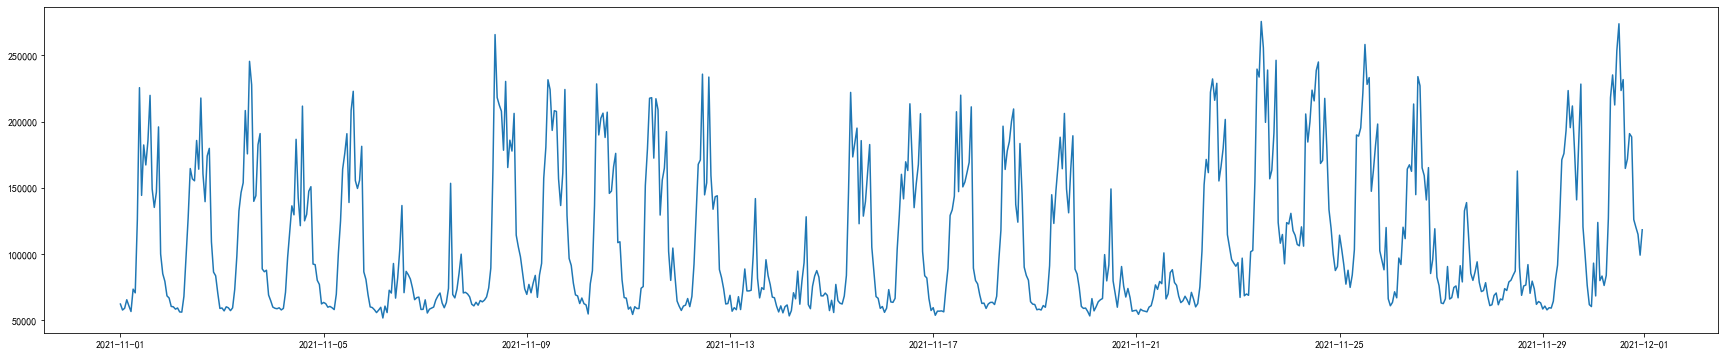

In [10]:
plt.figure(figsize=(30,6))
plt.plot(raw_data["time"],raw_data["AP"])

In [12]:
raw_data=raw_data.iloc[:,[1]]
raw_data

,AP
0,62183.0
1,57670.3
2,59028.8
3,65444.2
4,60853.0
...,...
715,125994.3
716,120218.9
717,114813.2
718,99124.0


## LSTM

### 首先分别对AP试一下

Epoch 1/10
160/160 - 1s - loss: 0.0551
Epoch 2/10
160/160 - 0s - loss: 0.0306
Epoch 3/10
160/160 - 0s - loss: 0.0241
Epoch 4/10
160/160 - 0s - loss: 0.0209
Epoch 5/10
160/160 - 0s - loss: 0.0195
Epoch 6/10
160/160 - 0s - loss: 0.0191
Epoch 7/10
160/160 - 0s - loss: 0.0190
Epoch 8/10
160/160 - 0s - loss: 0.0189
Epoch 9/10
160/160 - 0s - loss: 0.0188
Epoch 10/10
160/160 - 0s - loss: 0.0191
Train RMSE: 10003.50 RMSE
Test RMSE: 11197.19 RMSE
Test Score: 0.10060917 RATIO


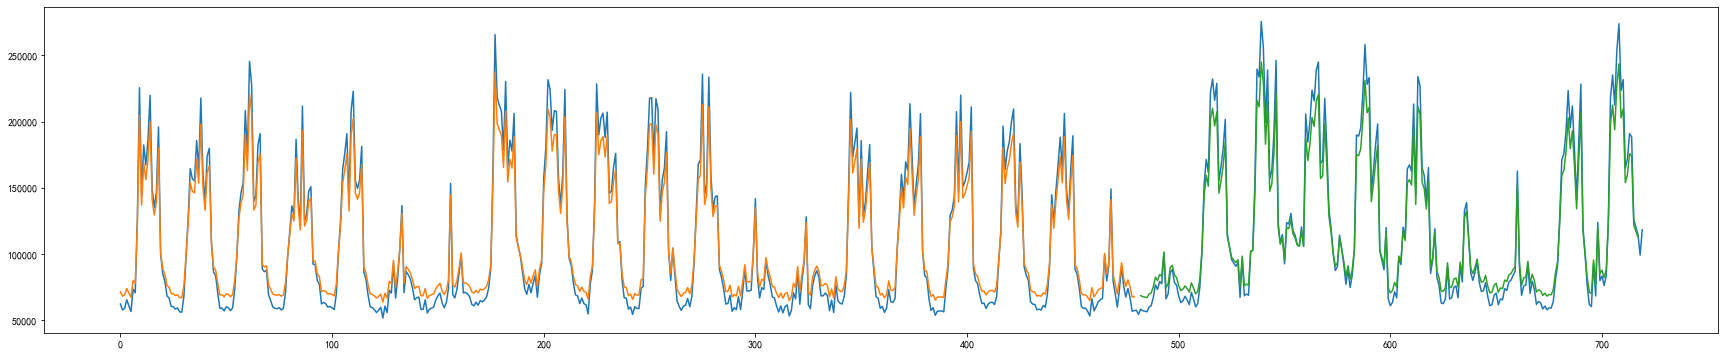

In [89]:
import math
import numpy as np
import pydot
import graphviz
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
  
# 创建数据集
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 加载数据
dataset = raw_data.values  
    
# 数据处理，归一化至0~1之间
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
    
# 划分训练集和测试集
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
# 创建测试集和训练集
look_back = 1
trainX, trainY = create_dataset(train, look_back)           #单步预测
testX, testY = create_dataset(test, look_back)
    
# 调整输入数据的格式
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))#（样本个数，1，输入的维度）
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
######################################## 创建LSTM神经网络模型##############################################
model = Sequential()
model.add(LSTM(10, input_shape=(trainX.shape[1], trainX.shape[2])))#输入维度为1，时间窗的长度为1，隐含层神经元节点个数为120
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=3, verbose=2)
    
# 预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
    
# 反归一化
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
    
# 计算得分
#a=np.min(testPredict[:,0])
#b=np.min(trainPredict[:,0])
#testPredict[:,0][testPredict[:,0]<=a] = 0
#trainPredict[:,0][trainPredict[:,0]<=b] = 0

trainRMSE = math.sqrt(mean_squared_error(trainY[0][:len(trainPredict)-1], trainPredict[1:,0]))
print('Train RMSE: %.2f RMSE' % (trainRMSE))
testRMSE = math.sqrt(mean_squared_error(testY[0][:len(testPredict)-1], testPredict[1:,0]))
print('Test RMSE: %.2f RMSE' % (testRMSE))
testRatio=testRMSE /(raw_data["AP"].mean())
print('Test Score: %.8f RATIO' % (testRatio))
    
# 绘图
plt.figure(figsize=(30,6))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot[1:])
plt.plot(testPredictPlot[1:])
plt.show()

### 【弃用】对AP之外的其他变量都纳入x试一下

In [59]:
raw = pd.read_csv(RAW_DATA).iloc[:,2:]
dataset=raw

In [60]:
"""
---------------------------
Question: Series  --->  Supervised Learning Problem
    时间序列预测，以前一时刻（t-1）的所有数据预测当前时刻（t）的值
    X = AP(t-1)，其他所有变量(t-1)
    Y = AP(t)
---------------------------
"""
import pandas as pd
from util import PROCESS_LEVEL1
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from series_to_supervised_learning import series_to_supervised

cols = list(dataset)
cols.insert(0,cols.pop(cols.index('AP'))) 
dataset = dataset.loc[:,cols] 

dataset_columns = dataset.columns
values = dataset.values

# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 将序列数据转化为监督学习数据
reframed = series_to_supervised(scaled, dataset_columns, 1, 1)

# 只考虑当前时刻(t)的前一时刻（t-1）的AP
reframed.drop(reframed.columns[range(27,52)], axis=1, inplace=True)

values = reframed.values

n_train_hours = 482
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# 监督学习结果划分
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# 为了在LSTM中应用该数据，需要将其格式转化为3D format，即[Samples, timesteps, features]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


Epoch 1/10
241/241 [==============================] - 2s 3ms/step - loss: 0.0323 - val_loss: 0.0195
Epoch 2/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0151
Epoch 3/10
241/241 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0156
Epoch 4/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0170
Epoch 5/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0139
Epoch 6/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0160
Epoch 7/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0136
Epoch 8/10
241/241 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0186
Epoch 9/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0216
Epoch 10/10
241/241 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0165

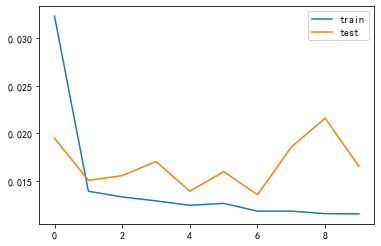

Test RMSE: 23921.420


In [70]:
from keras import Sequential
from keras.layers import LSTM, Dense
#from data_tranform import scaler, test_x, train_X, test_X, train_y, test_y
import matplotlib.pyplot as plt
from numpy import concatenate  # 数组拼接
from math import sqrt
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(train_X, train_y, epochs=10, batch_size=2, validation_data=(test_X, test_y))

'''
    对数据绘图
'''
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make the prediction,为了在原始数据的维度上计算损失，需要将数据转化为原来的范围再计算损失
yHat = model.predict(test_X)

'''
    这里注意的是保持拼接后的数组  列数  需要与之前的保持一致
'''
inv_yHat = concatenate((yHat, test_x[:, 1:]), axis=1)   # 数组拼接
inv_yHat = scaler.inverse_transform(inv_yHat)
inv_yHat = inv_yHat[:,0]

inv_y=dataset.iloc[482:719,0].values

rmse = sqrt(mean_squared_error(inv_yHat, inv_y))
print('Test RMSE: %.3f' % rmse)

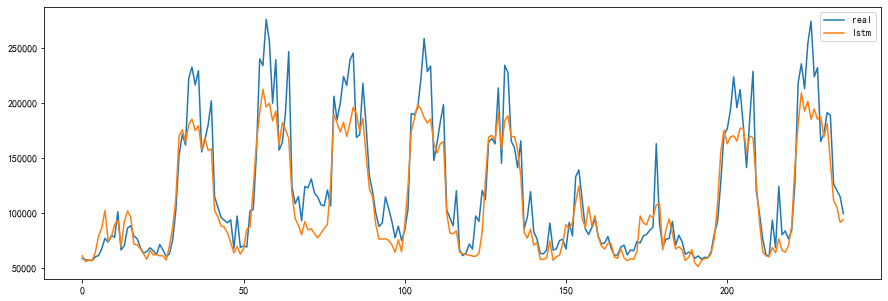

In [71]:
plt.figure(figsize=(15,5))
plt.plot(inv_y)
plt.plot(inv_yHat,"-")
plt.legend(['real','lstm'])